In [4]:
#setup&imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import( classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

from xgboost import XGBClassifier

In [8]:
#load_Titanic_Dataset(Seaborn)

df = sns.load_dataset('titanic')
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [6]:
#standardise columns and select features
#Features: pclass,sex,age,sibsp,parch,Fare,Embarked
#Target: Survived(0/1)

#create_copy

df_orig= df.copy()

#Normalise column names to lowercase for uniformity/consistency
df.columns= [c.strip().lower() for c in df.columns]

#Map common column names across seaborn/kaggle (selecting only which are required)
col_map= {
    "pclass":"pclass", "sex":"sex", "age":"age",
    "sibsp":"sibsp", "parch" : "parch", "fare":"fare", 
    "embarked":"embarked", "survived":"survived"}

#Ensuring required columns exist
required= ["pclass", "sex", "age","sibsp","parch", "fare", "embarked", "survived"]
missing= [c for c in required if c not in df.columns]

if missing:
    raise ValueError(f"Missing required columns in dataset: {missing}")

#keeping only selected feature set
feature_cols= ["pclass", "sex", "age","sibsp","parch", "fare", "embarked"]

X=df[feature_cols].copy()
y=df["survived"].astype(int).values

print("X_shape:", X.shape, "| Y_shape:",y.shape)
X.head()

X_shape: (891, 7) | Y_shape: (891,)


,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [7]:
#Train/test split(stratified)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:",X_train.shape[0], " | Test size:",X_test.shape[0])

Train size: 712  | Test size: 179


In [9]:
#Preprocessing + One_hot_encoding +modelling

categorical_features= ["pclass", "sex", "embarked"]
numeric_features= ["age","sibsp", "parch", "fare"]

categorical_pipeline= Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse= True))
])

numeric_pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)) #allow sparse passthrough if needed
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_pipeline, categorical_features),
        ("num", numeric_pipeline, numeric_features),
    ],
    remainder="drop"
)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",          
    tree_method="hist",         
    random_state=42,
    n_estimators=300,           
    learning_rate=0.1,          
    max_depth=4,
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", xgb)
])
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=Fa

In [10]:
#kfold statified CV + gridsearch CV
#Tune regulariszation and class weight

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4, 5],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 2.0], 
}
scoring = {
    "accuracy": "accuracy", "f1": "f1", "precision": "precision", "recall": "recall", "roc_auc": "roc_auc"}

grid = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring=scoring, refit="f1", cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", f"{grid.best_score_:.4f}")

best_model = grid.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 1.0, 'clf__subsample': 1.0}
Best CV F1: 0.7561


In [11]:
#Evaluate on held out test_set

# Predictions & probabilities
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # probability of class 1 (survived)

# Scalar metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Test F1:           {f1:.4f}")
print(f"Test Precision:    {precision:.4f}")
print(f"Test Recall:       {recall:.4f}")
print(f"Test ROC AUC:      {roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Not Survived", "Survived"]))

Test F1:           0.7465
Test Precision:    0.7794
Test Recall:       0.7162
Test ROC AUC:      0.8816

Classification report:
              precision    recall  f1-score   support

Not Survived       0.81      0.86      0.83       105
    Survived       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



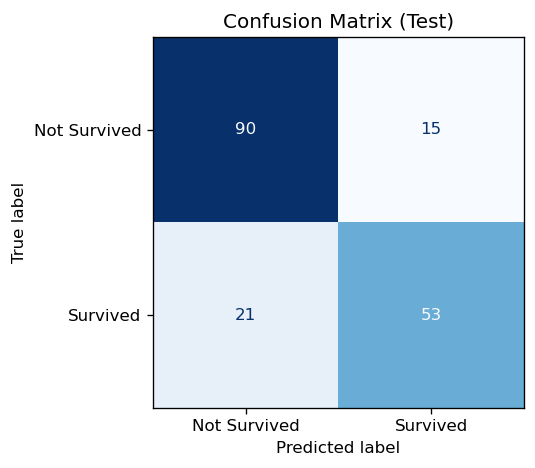

In [12]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

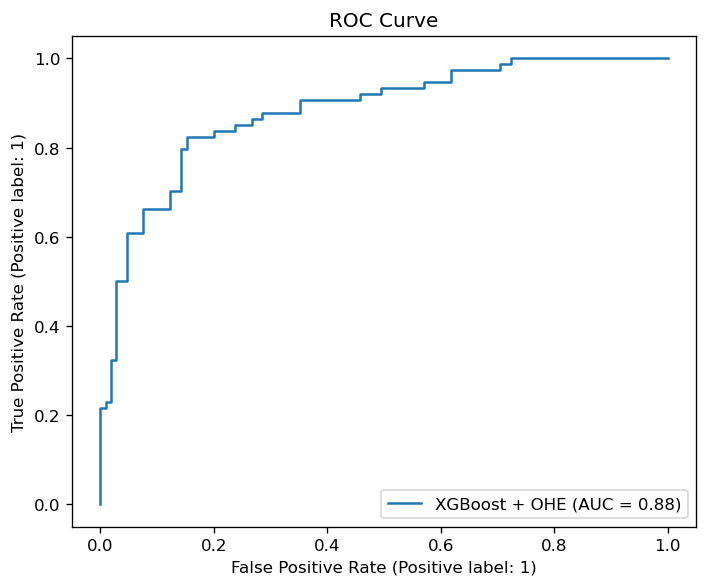

In [16]:
#ROC Curve (Binary) 

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test, ax=ax, name="XGBoost + OHE"
)
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

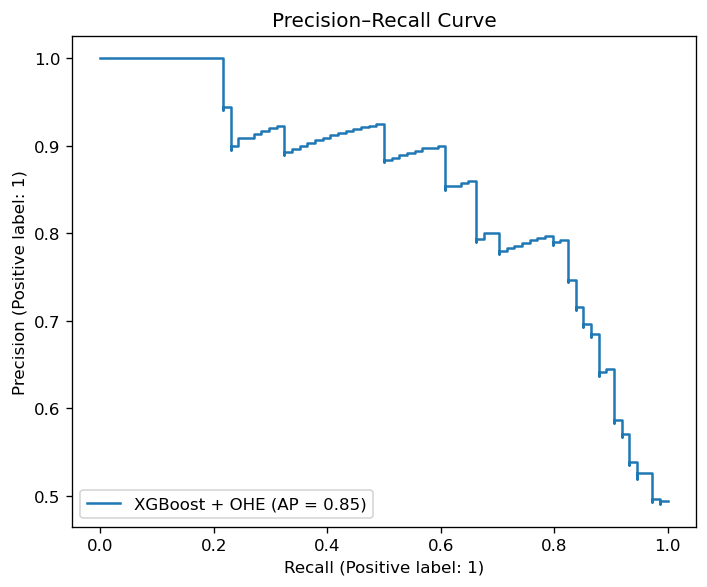

In [17]:
#Precision–Recall Curve

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
PrecisionRecallDisplay.from_estimator(
    best_model, X_test, y_test, ax=ax, name="XGBoost + OHE"
)
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

In [18]:
#Save the Best Model


import joblib
joblib.dump(best_model, "titanic_ohe_xgb_best_model.joblib")


['titanic_ohe_xgb_best_model.joblib']